In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os, random, numpy as np, tensorflow as tf


In [57]:
CSV_PATH = './../data/GOOGL_1h.csv'
DATE_COL = 'Datetime'

SEQ_LENGTH = 60
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100
TEST_RATIO = 0.1
VAL_SPLIT = 0.1

FEATURES = [
    ("Close", "minmax"),
    ("Volume", "minmax"),
    ("rsi_14", "minmax"),
    ("rsi_28", "minmax"),
    ("rsi_7", "minmax"),
    ("macd", "standard"),
    ("ema_20", "standard"),
    ("ema_50", "standard"),
    ("stoch_k", "minmax"),
    ("stoch_d", "minmax"),
    ("roc", "standard"),
    ("adx", "minmax"),
    ("di_plus", "minmax"),
    ("di_minus", "minmax"),
    ("atr", "standard"),
    ("close_pos", "none"),
    ("body_range_ratio", "none"),
]

TARGET = 'direction'


TRAINING_RANGE = [('2024-01-11 14:30:00+00:00', '2025-06-17 17:30:00+00:00')]
TESTING_RANGE = [('2025-06-17 18:30:00+00:00', '2025-11-14 20:30:00+00:00')]

In [58]:
SEED = 42
os.environ["PYTHONHASHSEED"]=str(SEED)
os.environ["TF_DETERMINISTIC_OPS"]="1"
os.environ["TF_CUDNN_DETERMINISTIC"]="1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# optionally limit threads
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


In [59]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
feature_names = [f[0] for f in FEATURES]
df = df[[DATE_COL] + feature_names + [TARGET]]
df.dropna(inplace=True)

feature_data = df[feature_names]
target_data = df[[TARGET]].values

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+----+-----------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+--------------------------+--------------------------+-------------------------+-------------------------+-----------------------+---------------------+-------------------------+--------------------------+-----------------------+-------------------------+--------------------------------+
|    |   ('Close', 'minmax') |   ('Volume', 'minmax') |   ('rsi_14', 'minmax') |   ('rsi_28', 'minmax') |   ('rsi_7', 'minmax') |   ('macd', 'standard') |   ('ema_20', 'standard') |   ('ema_50', 'standard') |   ('stoch_k', 'minmax') |   ('stoch_d', 'minmax') |   ('roc', 'standard') |   ('adx', 'minmax') |   ('di_plus', 'minmax') |   ('di_minus', 'minmax') |   ('atr', 'standard') |   ('close_pos', 'none') |   ('body_range_ratio', 'none') |
|----+-----------------------+------------------------+------------------------+------------------------+---------

In [60]:
if TEST_RATIO != None:
    train_test_split = int(len(df) * (1 - TEST_RATIO))
    date_train_beg = df[DATE_COL].iloc[0]
    date_train_end = df[DATE_COL].iloc[train_test_split - 1]
    date_test_beg = df[DATE_COL].iloc[train_test_split]
    date_test_end = df[DATE_COL].iloc[-1]
    TRAINING_RANGE = [(date_train_beg, date_train_end)]
    TESTING_RANGE = [(date_test_beg, date_test_end)]
print(f"Training range: {TRAINING_RANGE}")
print(f"Testing range: {TESTING_RANGE}")

Training range: [(Timestamp('2024-01-11 14:30:00+0000', tz='UTC'), Timestamp('2025-09-11 17:30:00+0000', tz='UTC'))]
Testing range: [(Timestamp('2025-09-11 18:30:00+0000', tz='UTC'), Timestamp('2025-11-14 20:30:00+0000', tz='UTC'))]


In [61]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (3172, 60, 17)
Target data shape: (3172, 1)


In [62]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

def get_samples_in_range(df, start_date, end_date):
    beg, end = find_closest_date_index(dates, start_date), find_closest_date_index(dates, end_date)
    _x, _y = X[beg:end+1], y[beg:end+1]
    return _x, _y, beg, end


X_train_val, y_train_val = [], []
for beg, end in TRAINING_RANGE:
    _x, _y, _, _ = get_samples_in_range(df, beg, end)
    X_train_val.extend(_x)
    y_train_val.extend(_y)

split_index = int(len(X_train_val) * (1 - VAL_SPLIT))
X_train, y_train = X_train_val[:split_index], y_train_val[:split_index]
X_val, y_val = X_train_val[split_index:], y_train_val[split_index:]

X_test, y_test = [], []
test_dates = []
for beg, end in TESTING_RANGE:
    _x, _y, d_beg, d_end = get_samples_in_range(df, beg, end)
    X_test.extend(_x)
    y_test.extend(_y)
    test_dates.extend(dates[d_beg:d_end+1])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

feature_scalers = {}

for idx, (feat_name, scaler_type) in enumerate(FEATURES):
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        # Fit only using training data
        scaler.fit(X_train[:, :, idx].reshape(-1, 1))

        # Apply scaling across all datasets
        X_train[:, :, idx] = scaler.transform(X_train[:, :, idx].reshape(-1, 1)).reshape(
            X_train.shape[0], X_train.shape[1]
        )
        if VAL_SPLIT > 0.0:
            X_val[:, :, idx] = scaler.transform(X_val[:, :, idx].reshape(-1, 1)).reshape(
                X_val.shape[0], X_val.shape[1]
            )
        X_test[:, :, idx] = scaler.transform(X_test[:, :, idx].reshape(-1, 1)).reshape(
            X_test.shape[0], X_test.shape[1]
        )

    feature_scalers[feat_name] = scaler

print(tb.tabulate(X_train[0][:5], headers=FEATURES, tablefmt='psql'))

def print_class_ratios(y, name):
    import numpy as np
    vals, counts = np.unique(y.flatten(), return_counts=True)
    print(f"{name}: {dict(zip(vals, counts))}, total={len(y)}")

print_class_ratios(y_train, "train")
print_class_ratios(y_val,   "val")
print_class_ratios(y_test,  "test")

+-----------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+--------------------------+--------------------------+-------------------------+-------------------------+-----------------------+---------------------+-------------------------+--------------------------+-----------------------+-------------------------+--------------------------------+
|   ('Close', 'minmax') |   ('Volume', 'minmax') |   ('rsi_14', 'minmax') |   ('rsi_28', 'minmax') |   ('rsi_7', 'minmax') |   ('macd', 'standard') |   ('ema_20', 'standard') |   ('ema_50', 'standard') |   ('stoch_k', 'minmax') |   ('stoch_d', 'minmax') |   ('roc', 'standard') |   ('adx', 'minmax') |   ('di_plus', 'minmax') |   ('di_minus', 'minmax') |   ('atr', 'standard') |   ('close_pos', 'none') |   ('body_range_ratio', 'none') |
|-----------------------+------------------------+------------------------+------------------------+-----------------------+

/tmp/ipykernel_149343/672997652.py:2: UserWarning: no explicit representation of timezones available for np.datetime64
  target_date = np.datetime64(target_date)


In [63]:
def create_financial_model(seq_length, feature_count, learning_rate):
    inputs = layers.Input(shape=(seq_length, feature_count))

    x = layers.LSTM(96, return_sequences=True, recurrent_dropout=0.1)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(96, return_sequences=True, recurrent_dropout=0.1)(x)
    x = layers.LayerNormalization()(x)
    
    x = layers.Attention()([x, x]) 
    x = layers.GlobalAveragePooling1D()(x) 
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model = create_financial_model(SEQ_LENGTH, len(FEATURES), LEARNING_RATE)

In [64]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

val = (X_val, y_val) if VAL_SPLIT > 0 else None

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=val,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/100


2025-11-16 18:25:30.185494: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4884 - loss: 0.7874

2025-11-16 18:25:52.862667: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.4912 - loss: 0.7552 - val_accuracy: 0.4140 - val_loss: 0.7667 - learning_rate: 0.0010
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.5135 - loss: 0.7208 - val_accuracy: 0.4211 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.5088 - loss: 0.7120 - val_accuracy: 0.4140 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.5076 - loss: 0.7064 - val_accuracy: 0.5298 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.5185 - loss: 0.7013 - val_accuracy: 0.4561 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.4990 - loss: 0.7023 - val_accuracy: 0.4561 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5441 - loss: 0.7003
E

KeyboardInterrupt: 

In [ ]:
pred_probs = model.predict(X_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
y_true = y_test.flatten()

acc = accuracy_score(y_true, pred_labels)
f1 = f1_score(y_true, pred_labels)
auc = tf.keras.metrics.AUC()(y_true, pred_probs).numpy()
auc_roc = tf.keras.metrics.AUC(curve='ROC')(y_true, pred_probs).numpy()

print(f"AUC:       {auc:.3f}")
print(f"AUC ROC:   {auc_roc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, pred_labels))

2025-11-16 18:03:33.066436: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
Accuracy:  0.546
F1 Score:  0.661
Confusion Matrix:
[[ 34 115]
 [ 32 143]]


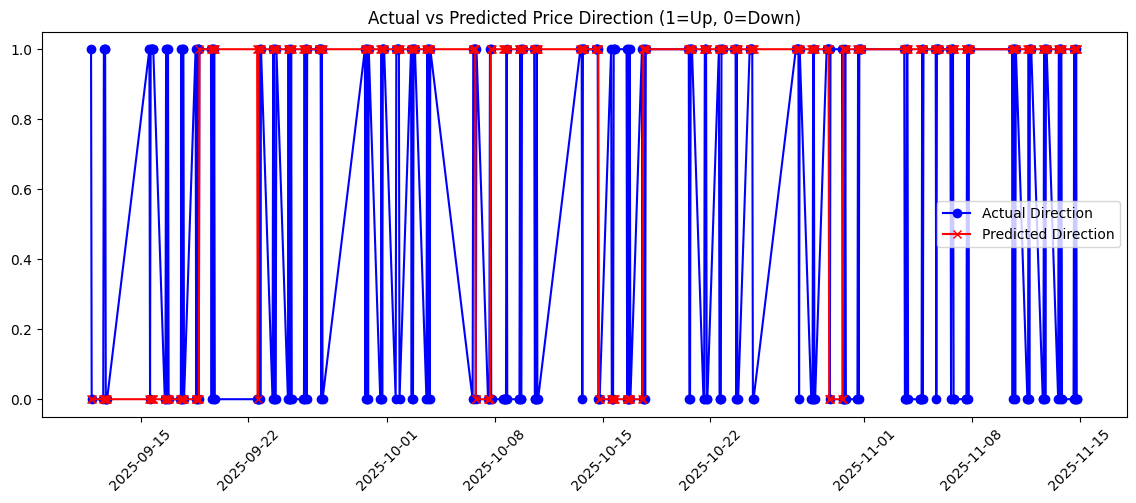

In [ ]:
dates = test_dates
plt.figure(figsize=(14, 5))
plt.plot(dates, y_true, label='Actual Direction', color='blue', marker='o')
plt.plot(dates, pred_labels, label='Predicted Direction', color='red', marker='x')
plt.title('Actual vs Predicted Price Direction (1=Up, 0=Down)')
plt.xticks(rotation=45) 
plt.legend()
plt.show()